In [48]:
import os
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# import numpy as np
import json
from disinfo_net_train_classifier import main
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from preprocess import ColumnSelector, TypeSelector, ImportanceModelPreprocessor 
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Get our features Datasets

In [2]:
fake_path = os.path.join(os.path.dirname(os.getcwd()), "results", "db_features", "FK_features.csv")
not_fake_path = os.path.join(os.path.dirname(os.getcwd()), "results", "db_features", "NFK_features.csv")

In [3]:
fake = pd.read_csv(fake_path)
fake = fake.drop(fake.columns[0], axis=1)
fake.head(2)

,domain,num_iframes,has_social_media,num_images,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,...,time from updated,whois lifetime,domain proxy,registrar,registrant country,registrant org,nameserver sld,nameserver asn,nameserver geoloc,target
0,horabrasilia.com.br,0,NaN,NaN,True,True,True,False,NaN,['Hora Brasília | Acompanhe as Principais Notí...,...,-1537.0,1461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disinformation
1,stuppid.com,4,False,12.0,True,True,True,False,NaN,['Mind-blowing News Stories And Interviews'],...,-1567.0,4383.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",domaincontrol.com,44273.0,US,disinformation


In [4]:
not_fake = pd.read_csv(not_fake_path)
target = ["not_disinformation"]*len(not_fake)
not_fake["target"] = target
not_fake = not_fake.drop(not_fake.columns[0], axis=1)
not_fake.head(2)

,domain,num_iframes,has_social_media,num_images,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,...,time from updated,whois lifetime,domain proxy,registrar,registrant country,registrant org,nameserver sld,nameserver asn,nameserver geoloc,target
0,rutan.dev,4,True,1.0,True,True,True,False,NaN,['RPGツクールMVやRPGツクールMZのプラグインを公開しています'],...,-1500.0,1826.0,True,Google LLC,CA,Contact Privacy Inc. Customer 7151571251,awsdns-59.org,16509.0,US,not_disinformation
1,timescall.com,0,NaN,NaN,True,True,True,False,NaN,"['Longmont, Colorado breaking news, sports, bu...",...,-1548.0,8683.0,True,Google LLC,CA,Contact Privacy Inc. Customer 7151571251,dnsmadeeasy.com,16552.0,US,not_disinformation


In [5]:
df_original = pd.concat([fake, not_fake], ignore_index=True)
df_original.head(2)

,domain,num_iframes,has_social_media,num_images,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,...,time from updated,whois lifetime,domain proxy,registrar,registrant country,registrant org,nameserver sld,nameserver asn,nameserver geoloc,target
0,horabrasilia.com.br,0,NaN,NaN,True,True,True,False,NaN,['Hora Brasília | Acompanhe as Principais Notí...,...,-1537.0,1461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disinformation
1,stuppid.com,4,False,12.0,True,True,True,False,NaN,['Mind-blowing News Stories And Interviews'],...,-1567.0,4383.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",domaincontrol.com,44273.0,US,disinformation


In [6]:
target_mapping = {"disinformation": 1, "not_disinformation": 0}
df_original["target_encoded"] = df_original["target"].map(target_mapping)
df_original.head(3)

,domain,num_iframes,has_social_media,num_images,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,...,whois lifetime,domain proxy,registrar,registrant country,registrant org,nameserver sld,nameserver asn,nameserver geoloc,target,target_encoded
0,horabrasilia.com.br,0,NaN,NaN,True,True,True,False,NaN,['Hora Brasília | Acompanhe as Principais Notí...,...,1461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disinformation,1
1,stuppid.com,4,False,12.0,True,True,True,False,NaN,['Mind-blowing News Stories And Interviews'],...,4383.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",domaincontrol.com,44273.0,US,disinformation,1
2,kan.org.il,7,True,169.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LiveDNS Ltd,NaN,NaN,cloudflare.com,13335.0,US,disinformation,1


In [8]:
X = df_original.drop(["target", "target_encoded"], axis=1)
y = df_original["target_encoded"]
X.head(3)

,domain,num_iframes,has_social_media,num_images,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,...,time to expiration,time from updated,whois lifetime,domain proxy,registrar,registrant country,registrant org,nameserver sld,nameserver asn,nameserver geoloc
0,horabrasilia.com.br,0,NaN,NaN,True,True,True,False,NaN,['Hora Brasília | Acompanhe as Principais Notí...,...,1870.0,-1537.0,1461.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,stuppid.com,4,False,12.0,True,True,True,False,NaN,['Mind-blowing News Stories And Interviews'],...,1932.0,-1567.0,4383.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",domaincontrol.com,44273.0,US
2,kan.org.il,7,True,169.0,NaN,NaN,NaN,NaN,NaN,NaN,...,1956.0,NaN,NaN,NaN,LiveDNS Ltd,NaN,NaN,cloudflare.com,13335.0,US


### 2. Select features we want to analyse

In [9]:
def replace_spaces_with_underscore(strings_list):
    return [s.replace(' ', '_') for s in strings_list]

In [10]:
current_columns = X.columns.tolist()
new_columns = replace_spaces_with_underscore(current_columns)
column_mapping = dict(zip(current_columns, new_columns))
X.rename(columns=column_mapping, inplace=True)

In [12]:
desired_features_names = ["html_features", "domain_features", "cert_features", "whois_features"]
# colect all columns names
config_dir = os.path.join("/Users/irisdamiao/model/Project/config_copy.json")
with open(config_dir) as file:
    all_features_name = json.load(file)

desired_features = []
for name in desired_features_names:
    if name == "html_features":
        names = all_features_name[name]
        for n in names:
            desired_features.extend(names[n])
    else: 
        desired_features.extend(all_features_name[name])

desired_features = replace_spaces_with_underscore(desired_features)

In [13]:
def remove_ft_prefix(string):
    if string.startswith("ft_"):
        return string[3:]  # Remove the first three characters (i.e., "ft_")
    return string

In [14]:
desired_features = [remove_ft_prefix(x) for x in desired_features]
desired_features = [item for item in desired_features if item not in ['domain_ip_info', 'nameserver_ip_info']]

In [15]:
X_features = X[desired_features]

### 3. Clean features to feed RF

In [16]:
import numpy as np

#### 3.1 Categorical Variables 

3.1.1. Take care of categorical values very dificult to handle -> measure length instead of words

In [17]:
def count_words(input_string):
    if (isinstance(input_string, int) == False):
        string = input_string[0]
        if isinstance(string, str):
            words = input_string.split()
            return len(words)
    else: return input_string

In [18]:
X_features["description_in_tag"].fillna(0, inplace=True)
X_features["keywords_in_tag"].fillna(0, inplace=True)

In [19]:
X_features["description_in_tag"] = X_features["description_in_tag"].apply(lambda x: count_words(x))
X_features["keywords_in_tag"] = X_features["keywords_in_tag"].apply(lambda x: count_words(x))

Check if it worked!

In [20]:
X_features

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,has_cert,creation_elapsed_time,time_to_expiration,time_from_updated,whois_lifetime,domain_proxy,registrar,registrant_country,registrant_org,nameserver_sld
0,0,NaN,True,True,True,False,0,21,NaN,False,...,True,-409.0,1870.0,-1537.0,1461.0,NaN,NaN,NaN,NaN,NaN
1,4,False,True,True,True,False,0,5,12.0,False,...,True,2451.0,1932.0,-1567.0,4383.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",domaincontrol.com
2,7,True,NaN,NaN,NaN,NaN,0,0,169.0,False,...,True,NaN,1956.0,NaN,NaN,NaN,LiveDNS Ltd,NaN,NaN,cloudflare.com
3,7,False,True,True,True,False,0,8,64.0,False,...,True,7845.0,4938.0,-1576.0,12783.0,False,"Gabia, Inc.",NaN,NaN,naver.com
4,3,True,True,False,True,False,0,16,141.0,False,...,True,7670.0,1647.0,-1282.0,9317.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",nsone.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1,True,True,False,False,False,0,0,17.0,False,...,True,8393.0,1835.0,-1534.0,10228.0,False,"GoDaddy Corporate Domains, LLC",US,Gannett Media Corp,nsone.net
639,1,True,NaN,NaN,NaN,NaN,0,0,29.0,False,...,True,2725.0,1658.0,NaN,4383.0,False,RU-CENTER-RU,NaN,NaN,yandex.ru
640,0,False,False,False,True,True,4,23,97.0,True,...,True,529.0,1662.0,NaN,2191.0,False,REGRU-RU,NaN,NaN,webhost1.com
641,5,False,True,True,True,False,0,19,29.0,False,...,True,572.0,1985.0,-1585.0,2557.0,True,"Amazon Registrar, Inc.",GB,Identity Protection Service,cloudflare.com


3.1.2 Handle features that are boolean, but because of NaN values are being considered categorical

In [21]:
class BooleanTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.bool_cols = [col for col in X.columns if X[col].dtype == 'O' and set(X[col].unique()) == {False, np.nan, True}]
        self.imputer = SimpleImputer(strategy='most_frequent').fit(X[self.bool_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.bool_cols] = self.imputer.transform(X_copy[self.bool_cols])
        X_copy[self.bool_cols] = X_copy[self.bool_cols].astype(bool)
        return X_copy

In [22]:
X_boolean_treated = BooleanTransformer().fit_transform(X_features)

In [23]:
X_boolean_treated

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,has_cert,creation_elapsed_time,time_to_expiration,time_from_updated,whois_lifetime,domain_proxy,registrar,registrant_country,registrant_org,nameserver_sld
0,0,True,True,True,True,False,0,21,NaN,False,...,True,-409.0,1870.0,-1537.0,1461.0,False,NaN,NaN,NaN,NaN
1,4,False,True,True,True,False,0,5,12.0,False,...,True,2451.0,1932.0,-1567.0,4383.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",domaincontrol.com
2,7,True,True,True,True,False,0,0,169.0,False,...,True,NaN,1956.0,NaN,NaN,False,LiveDNS Ltd,NaN,NaN,cloudflare.com
3,7,False,True,True,True,False,0,8,64.0,False,...,True,7845.0,4938.0,-1576.0,12783.0,False,"Gabia, Inc.",NaN,NaN,naver.com
4,3,True,True,False,True,False,0,16,141.0,False,...,True,7670.0,1647.0,-1282.0,9317.0,True,"GoDaddy.com, LLC",US,"Domains By Proxy, LLC",nsone.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1,True,True,False,False,False,0,0,17.0,False,...,True,8393.0,1835.0,-1534.0,10228.0,False,"GoDaddy Corporate Domains, LLC",US,Gannett Media Corp,nsone.net
639,1,True,True,True,True,False,0,0,29.0,False,...,True,2725.0,1658.0,NaN,4383.0,False,RU-CENTER-RU,NaN,NaN,yandex.ru
640,0,False,False,False,True,True,4,23,97.0,True,...,True,529.0,1662.0,NaN,2191.0,False,REGRU-RU,NaN,NaN,webhost1.com
641,5,False,True,True,True,False,0,19,29.0,False,...,True,572.0,1985.0,-1585.0,2557.0,True,"Amazon Registrar, Inc.",GB,Identity Protection Service,cloudflare.com


3.1.3 Handle categorical values -> remove unecessary ones

In [24]:
categorical_features = X_boolean_treated.columns[X_boolean_treated.dtypes==object].tolist()
categorical_features

['has_expired',
 'issuer_country',
 'issuer_org',
 'registrar',
 'registrant_country',
 'registrant_org',
 'nameserver_sld']

In [25]:
X_pre_treated = X_boolean_treated.drop(["has_expired"], axis=1) # This feature does not matter in this case, because all websites are active

In [26]:
X_pre_treated = X_pre_treated.drop(["registrar"], axis=1)

In [27]:
X_pre_treated

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,san_contains_wildcard,has_cert,creation_elapsed_time,time_to_expiration,time_from_updated,whois_lifetime,domain_proxy,registrant_country,registrant_org,nameserver_sld
0,0,True,True,True,True,False,0,21,NaN,False,...,True,True,-409.0,1870.0,-1537.0,1461.0,False,NaN,NaN,NaN
1,4,False,True,True,True,False,0,5,12.0,False,...,True,True,2451.0,1932.0,-1567.0,4383.0,True,US,"Domains By Proxy, LLC",domaincontrol.com
2,7,True,True,True,True,False,0,0,169.0,False,...,True,True,NaN,1956.0,NaN,NaN,False,NaN,NaN,cloudflare.com
3,7,False,True,True,True,False,0,8,64.0,False,...,False,True,7845.0,4938.0,-1576.0,12783.0,False,NaN,NaN,naver.com
4,3,True,True,False,True,False,0,16,141.0,False,...,False,True,7670.0,1647.0,-1282.0,9317.0,True,US,"Domains By Proxy, LLC",nsone.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1,True,True,False,False,False,0,0,17.0,False,...,True,True,8393.0,1835.0,-1534.0,10228.0,False,US,Gannett Media Corp,nsone.net
639,1,True,True,True,True,False,0,0,29.0,False,...,False,True,2725.0,1658.0,NaN,4383.0,False,NaN,NaN,yandex.ru
640,0,False,False,False,True,True,4,23,97.0,True,...,False,True,529.0,1662.0,NaN,2191.0,False,NaN,NaN,webhost1.com
641,5,False,True,True,True,False,0,19,29.0,False,...,True,True,572.0,1985.0,-1585.0,2557.0,True,GB,Identity Protection Service,cloudflare.com


In [28]:
col_trans = X_pre_treated.columns[X_pre_treated.dtypes==object].tolist()
col_trans

['issuer_country',
 'issuer_org',
 'registrant_country',
 'registrant_org',
 'nameserver_sld']

3.1.4 Treat numerical features. Drop NaN by 0

In [29]:
numeric_columns = X_pre_treated.select_dtypes(include="number").columns
X_pre_treated[numeric_columns] = X_pre_treated[numeric_columns].apply(pd.to_numeric, errors="coerce")

In [30]:
X_pre_treated

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,san_contains_wildcard,has_cert,creation_elapsed_time,time_to_expiration,time_from_updated,whois_lifetime,domain_proxy,registrant_country,registrant_org,nameserver_sld
0,0,True,True,True,True,False,0,21,NaN,False,...,True,True,-409.0,1870.0,-1537.0,1461.0,False,NaN,NaN,NaN
1,4,False,True,True,True,False,0,5,12.0,False,...,True,True,2451.0,1932.0,-1567.0,4383.0,True,US,"Domains By Proxy, LLC",domaincontrol.com
2,7,True,True,True,True,False,0,0,169.0,False,...,True,True,NaN,1956.0,NaN,NaN,False,NaN,NaN,cloudflare.com
3,7,False,True,True,True,False,0,8,64.0,False,...,False,True,7845.0,4938.0,-1576.0,12783.0,False,NaN,NaN,naver.com
4,3,True,True,False,True,False,0,16,141.0,False,...,False,True,7670.0,1647.0,-1282.0,9317.0,True,US,"Domains By Proxy, LLC",nsone.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1,True,True,False,False,False,0,0,17.0,False,...,True,True,8393.0,1835.0,-1534.0,10228.0,False,US,Gannett Media Corp,nsone.net
639,1,True,True,True,True,False,0,0,29.0,False,...,False,True,2725.0,1658.0,NaN,4383.0,False,NaN,NaN,yandex.ru
640,0,False,False,False,True,True,4,23,97.0,True,...,False,True,529.0,1662.0,NaN,2191.0,False,NaN,NaN,webhost1.com
641,5,False,True,True,True,False,0,19,29.0,False,...,True,True,572.0,1985.0,-1585.0,2557.0,True,GB,Identity Protection Service,cloudflare.com


In [31]:
for n in numeric_columns:
    X_pre_treated[n].fillna(0, inplace=True)
X_pre_treated

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,san_contains_wildcard,has_cert,creation_elapsed_time,time_to_expiration,time_from_updated,whois_lifetime,domain_proxy,registrant_country,registrant_org,nameserver_sld
0,0,True,True,True,True,False,0,21,0.0,False,...,True,True,-409.0,1870.0,-1537.0,1461.0,False,NaN,NaN,NaN
1,4,False,True,True,True,False,0,5,12.0,False,...,True,True,2451.0,1932.0,-1567.0,4383.0,True,US,"Domains By Proxy, LLC",domaincontrol.com
2,7,True,True,True,True,False,0,0,169.0,False,...,True,True,0.0,1956.0,0.0,0.0,False,NaN,NaN,cloudflare.com
3,7,False,True,True,True,False,0,8,64.0,False,...,False,True,7845.0,4938.0,-1576.0,12783.0,False,NaN,NaN,naver.com
4,3,True,True,False,True,False,0,16,141.0,False,...,False,True,7670.0,1647.0,-1282.0,9317.0,True,US,"Domains By Proxy, LLC",nsone.net
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1,True,True,False,False,False,0,0,17.0,False,...,True,True,8393.0,1835.0,-1534.0,10228.0,False,US,Gannett Media Corp,nsone.net
639,1,True,True,True,True,False,0,0,29.0,False,...,False,True,2725.0,1658.0,0.0,4383.0,False,NaN,NaN,yandex.ru
640,0,False,False,False,True,True,4,23,97.0,True,...,False,True,529.0,1662.0,0.0,2191.0,False,NaN,NaN,webhost1.com
641,5,False,True,True,True,False,0,19,29.0,False,...,True,True,572.0,1985.0,-1585.0,2557.0,True,GB,Identity Protection Service,cloudflare.com


In [32]:
categorical_df = X_pre_treated[col_trans]
encoder = OneHotEncoder()
encoded_data = encoder.fit_transform(categorical_df)
encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(col_trans))

In [33]:
encoded_df

,issuer_country_AT,issuer_country_BE,issuer_country_FR,issuer_country_GB,issuer_country_LU,issuer_country_PL,issuer_country_US,issuer_country_nan,issuer_org_Amazon,issuer_org_Apple Inc.,...,nameserver_sld_worldnic.com,nameserver_sld_wpxhosting.com,nameserver_sld_xhosting.ir,nameserver_sld_yahoo.com,nameserver_sld_yandex.net,nameserver_sld_yandex.ru,nameserver_sld_zenon.net,nameserver_sld_zoneedit.com,nameserver_sld_zvezdamedia.ru,nameserver_sld_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_pre_treated.drop(columns=col_trans, inplace=True)

In [35]:
X_treated_2 = pd.concat([X_pre_treated, encoded_df], axis=1)
X_treated_2

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,nameserver_sld_worldnic.com,nameserver_sld_wpxhosting.com,nameserver_sld_xhosting.ir,nameserver_sld_yahoo.com,nameserver_sld_yandex.net,nameserver_sld_yandex.ru,nameserver_sld_zenon.net,nameserver_sld_zoneedit.com,nameserver_sld_zvezdamedia.ru,nameserver_sld_nan
0,0,True,True,True,True,False,0,21,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,4,False,True,True,True,False,0,5,12.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,True,True,True,True,False,0,0,169.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7,False,True,True,True,False,0,8,64.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,True,True,False,True,False,0,16,141.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,1,True,True,False,False,False,0,0,17.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
639,1,True,True,True,True,False,0,0,29.0,False,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
640,0,False,False,False,True,True,4,23,97.0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
641,5,False,True,True,True,False,0,19,29.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Spliting the dataset training vs. testing

In [38]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(
        X_treated_2,  # X
        y,  # y
        test_size=0.2,  # Proportion of the dataset to include in the test split
        random_state=seed  # Random seed for reproducibility
    )

In [39]:
X_train

,num_iframes,has_social_media,has_og_tag,has_twitter_tag,has_description,has_keywords,keywords_in_tag,description_in_tag,num_images,contains_digit,...,nameserver_sld_worldnic.com,nameserver_sld_wpxhosting.com,nameserver_sld_xhosting.ir,nameserver_sld_yahoo.com,nameserver_sld_yandex.net,nameserver_sld_yandex.ru,nameserver_sld_zenon.net,nameserver_sld_zoneedit.com,nameserver_sld_zvezdamedia.ru,nameserver_sld_nan
329,5,True,True,True,True,False,0,12,104.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,3,False,True,True,True,False,0,15,93.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
600,7,False,False,False,True,False,0,0,103.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
575,2,True,True,True,True,False,0,0,51.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
433,5,True,True,True,True,True,5,16,150.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,False,False,False,True,False,0,0,15.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106,0,False,True,False,True,False,0,17,0.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270,0,False,True,False,True,True,1,23,0.0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
435,1,True,True,False,True,False,0,0,7.0,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


3.1.5 Create pipeline for random

In [40]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [41]:
y_pred = rf.predict(X_test)

In [42]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6744186046511628


In [43]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x169aa65f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x169aa6560>})

In [44]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 172}


In [45]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

Accuracy: 0.6976744186046512


#### Build a Confusion Matrix

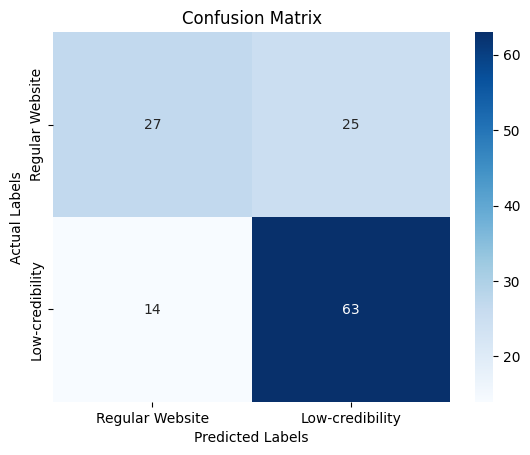

In [46]:
labels_x = ['Low-credibility', 'Regular Website']
labels_y = ['Regular Website', 'Low-credibility']
cm_labeled = np.array(cm).reshape(2, 2)

# Step 4: Visualize the confusion matrix as a heatmap
sns.heatmap(cm_labeled, annot=True, fmt='d', xticklabels=labels_y, yticklabels=labels_y, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.title('Confusion Matrix')
plt.show()

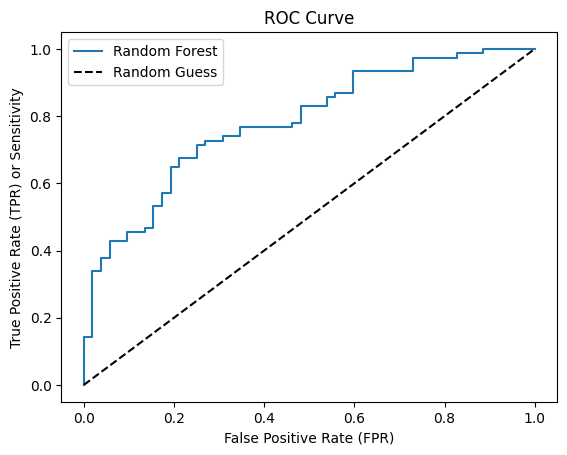

AUC: 0.78


In [49]:
y_probs = best_rf.predict_proba(X_test)[:, 1]
# Step 3: Compute the True Positive Rate (TPR) and False Positive Rate (FPR) using roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Step 4: Plot the ROC curve
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Sensitivity')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Step 5: Calculate the Area Under the ROC Curve (AUC)
auc_score = roc_auc_score(y_test, y_probs)
print(f'AUC: {auc_score:.2f}')


In [55]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [56]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
X_train = np.array(X_train, order='C')
X_test = np.array(X_test, order='C')

In [81]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5736434108527132
Precision: 0.4716981132075472
Recall: 0.4807692307692308


In [63]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index = X_train.columns).sort_values(ascending=False)
feature_10_most_important = feature_importances.head(15)
# Plot a simple bar chart
feature_10_most_important

num_images               0.059186
creation_elapsed_time    0.059022
whois_lifetime           0.054432
num_iframes              0.054368
description_in_tag       0.052521
time_to_expiration       0.050717
length                   0.048593
time_from_updated        0.048576
cert_lifetime            0.027192
san_length               0.023484
san_contains_wildcard    0.020799
has_og_tag               0.019843
keywords_in_tag          0.019585
has_social_media         0.016109
novelty_tld              0.014573
dtype: float64

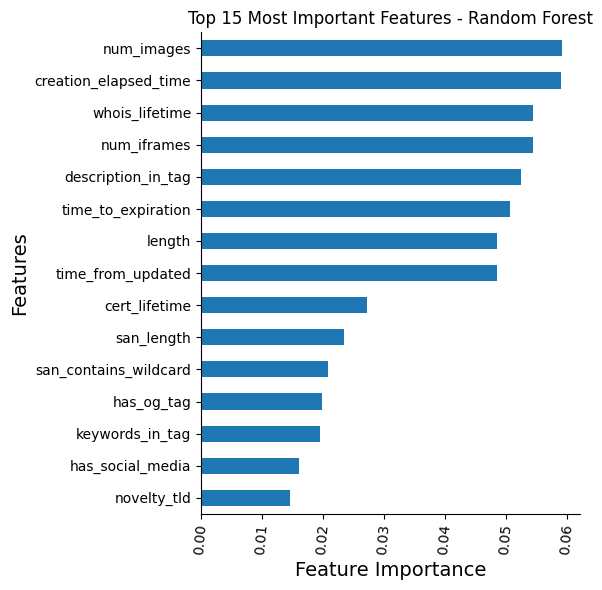

In [68]:
plt.figure(figsize=(6, 6))  # Adjust the figure size as per your preference

# Remove the box around the plot but keep the x and y axes
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Plot horizontal bar chart for feature importances
feature_10_most_important[::-1].plot(kind='barh')

# Add labels and title
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 15 Most Important Features - Random Forest')

# Adjust rotation of feature labels (in this example, I'm rotating them by 0 degrees)
plt.xticks(rotation=85)

plt.tight_layout()  # Adjust the layout to prevent label cutoffs

plt.show()